# Causal modeling of viewing social versus random moving shape

Load libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Basic parameters

In [ ]:
# The download cells will store the data in nested directories starting here:
HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

# Load data

## Load task fMRI data

In [ ]:
fname = "hcp_task.tgz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/s4h8j/download/
  !tar -xzf $fname -C $HCP_DIR --strip-components=1

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

# ROIs: temporoparietal junction, superior temporal sulcus, medial prefrontal cortex, fusiform gyrus, occipital gyrus, amygdala, insula 

# STS: STSdp, STSda, STSvp, STSva
# temporo-parietal-occipital junction:  TPOJ1,  TPOJ2,  TPOJ3
# ACC and mPFC: 33pr,  p24pr,  a24pr,  p24,  a24,  p32pr,  a32pr,  d32,  p32,  s32,  8BM,  9m, 10v,  10r,  and 25
# fusiform gyrus: FFC
# occipital gyrus: ???
# insula: Ig

# Helper functions


## Data loading

In [ ]:
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
    evs.append(ev)
  return evs


In [ ]:
# Load data from STS and TPJ


## Task-based analysis

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averaged across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Scratch

## Files

In [ ]:
for file in os.listdir(HCP_DIR):
  print(file)

subjects
._.DS_Store
regions.npy
._subjects
.DS_Store


In [ ]:
task_key = "tfMRI_SOCIAL_RL"
subject = 0

ev_dir = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/"
# ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"

for file in os.listdir(ev_dir):
  print(file)

._rnd.txt
._mental_resp.txt
._other_resp.txt
mental.txt
Sync.txt
mental_resp.txt
other_resp.txt
rnd.txt
._mental.txt
._Sync.txt


In [ ]:
ev_file = os.path.join(ev_dir,"mental_resp.txt")
ev_mental = pd.read_table(ev_file,names=["onset","duration","amplitude"])
ev_mental

,onset,duration,amplitude
0,8.197,23,1
1,122.057,23,1


In [ ]:
ev = dict(zip(["onset", "duration", "amplitude"], np.genfromtxt(ev_file).T))
print(ev)

{'onset': array([  8.197, 122.057]), 'duration': array([23., 23.]), 'amplitude': array([1., 1.])}


In [ ]:
subject = 0
ts = load_timeseries(subject, "SOCIAL", runs=None, concat=True, remove_mean=True)
np.shape(ts)

In [ ]:
get_image_ids("SOCIAL")

[17, 18]

## Regions

In [ ]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),
)

region_info = pd.DataFrame.from_dict(region_info)
region_info

,name,network,myelin
0,R_V1,Visual1,2.20900
1,R_MST,Visual2,2.05561
2,R_V6,Visual2,2.14980
3,R_V2,Visual2,2.15347
4,R_V3,Visual2,2.07251
...,...,...,...
355,L_STSva,Posterior-Mu,1.76080
356,L_TE1m,Frontopariet,1.74175
357,L_PI,Cingulo-Oper,1.74335
358,L_a32pr,Cingulo-Oper,1.73082


ROIs: temporoparietal junction, superior temporal sulcus, medial prefrontal cortex, fusiform gyrus, occipital gyrus, amygdala, insula 

- STS: STSdp, STSda, STSvp, STSva
- temporo-parietal-occipital junction:  TPOJ1,  TPOJ2,  TPOJ3
- ACC and mPFC: 33pr,  p24pr,  a24pr,  p24,  a24,  p32pr,  a32pr,  d32,  p32,  - s32,  8BM,  9m, 10v,  10r,  and 25
- fusiform gyrus: FFC
- occipital gyrus: ???
- insula: Ig

In [ ]:
# Finding indices of regions
regionsdf = pd.DataFrame.from_dict(region_info)
regionsdf[regionsdf['name'].str.contains("STS")]
STSidx = regionsdf.index[regionsdf['name'].str.contains("STS")].tolist() # get indices
print(STSidx[0])
TPOJidx = regionsdf.index[regionsdf['name'].str.contains("TPOJ")].tolist() # get indices
print(TPOJidx)

127
[138, 139, 140, 318, 319, 320]


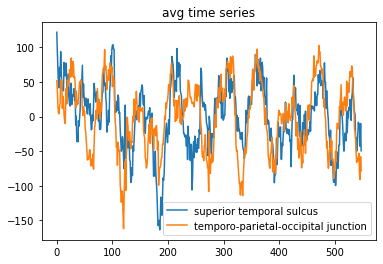

In [ ]:
# Loading time series for two regions and plotting
all_ts = load_timeseries(0, "SOCIAL", runs=None, concat=True, remove_mean=True)
# average over all STS regions
STS_ts = np.mean(all_ts[STSidx,],axis=0)
plt.plot(STS_ts,label = 'superior temporal sulcus') #avg time series in STS
TPOJ_ts = np.mean(all_ts[TPOJidx,],axis=0)
plt.plot(TPOJ_ts,label = 'temporo-parietal-occipital junction')
plt.title('avg time series')
plt.legend()

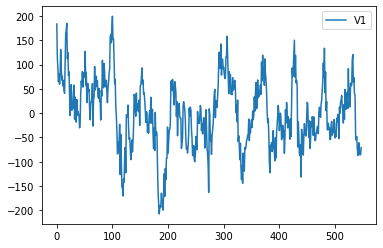

In [ ]:
# Pick a random region to compare - V1
V1idx = regionsdf.index[regionsdf['name'].str.contains("V1")].tolist() # get indices
V1_ts = np.mean(all_ts[V1idx,],axis = 0)
plt.plot(V1_ts,label='V1') 
V1idx = regionsdf.index[regionsdf['name'].str.contains("V1")].tolist() # get indices
V1_ts = np.mean(all_ts[V1idx,],axis = 0)
plt.plot(V1_ts,label='V1') 
plt.legend()

[0, 152, 180, 332]


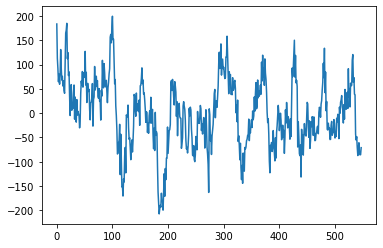

In [ ]:
from statsmodels.tsa.stattools import grangercausalitytests
STS_TPOJ_ts = np.vstack((STS_ts,TPOJ_ts)).T #combine two time series, one for each column
np.shape(STS_TPOJ_ts)
tests = grangercausalitytests(STS_TPOJ_ts,1,verbose=True)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.6329 , p=0.0000  , df_denom=544, df_num=1
ssr based chi2 test:   chi2=18.7356 , p=0.0000  , df=1
likelihood ratio test: chi2=18.4219 , p=0.0000  , df=1
parameter F test:         F=18.6329 , p=0.0000  , df_denom=544, df_num=1


In [ ]:
print(tests)
tests['params_ftest']

{1: ({'ssr_ftest': (18.632892992747692, 1.883005098248316e-05, 544.0, 1), 'ssr_chi2test': (18.73564791734005, 1.5014914435240222e-05, 1), 'lrtest': (18.421928099996876, 1.7700924939917693e-05, 1), 'params_ftest': (18.6328929927475, 1.883005098248433e-05, 544.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb024951940>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x7fb024951160>, array([[0., 1., 0.]])])}


KeyError: ignored